<h1 class="text-center">BCI - Decoding frequency-tagging: a SSVEP-based BCI</h1>
<h2 class="text-center">February, 2022</h2>

<br>

The purpose of this tutorial is to implement a reactive BCI using SSVEP on a dataset collected in our laboratory. You will use MNE to load and pre-process the data and Sklearn+MNE for the classification part. 
</b></div>

- In Section I, exploration data analysis, frequency analysis and epoching using MNE
- In Section II, a first classifier is trained on SNR at stimulation frequencies
- In Section III, another pipeline that uses Canonical Correlation Analysis with sinus templates to learn a spatial filter.
- In Section IV, a more advance pipeline based on Task Related Correlation Analysis that add individual templates from calibration data and temporal filterbank to CCA pipeline.
- The last section (V) explores more comfortable stimulation for SSVEP-based BCI (lower amplitude)

The code must be completed after each **Question** to work, where "HERE" appears as a comment in the code. The parameters that do not change the course of the story are accompanied "EDIT ME!" as a comment: you can change them at the time or at the end of the section to see the changes involved.

In [1]:
import mne
import os

import matplotlib.pyplot as plt

import numpy as np

from scipy.stats import ttest_rel
from scipy.signal import welch
from sklearn.cross_decomposition import CCA
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from utils.TRCA import TRCA

# I - Dataset exploration and pre-processing
In this session we will work with data acquired at ISAE-SUPAERO on Steady States Visually Evoked Potentials (SSVEP). EEG data was collected using 32 Ag/AgCl active electrodes. A 32-channel montage based on the international 10-20 system was used to record the EEG signals with a sampling rate of 500Hz. The EEG device used in this experiment was the Brain Products LiveAmp system. Brain data was recorded using the LabRecorder software and the experimental protocol was implemented using the Psychopy Python library. Events from the experimental paradigm were synchronized with the EEG signal recording using the Lab Streaming Layer (LSL) library.

**The subjects were asked to look at four different stimuli with rectangular shapes**. These stimuli flickered at different frequencies. Because of this difference in frequency, each stimuli elicits a different response in the Primary Visual Cortex, that we can classify in order to know at which target the participants were looking at each trial.

## We load the data and plot the sensor location
The data is presented in [EEGLAB .set format](https://eeglab.org/tutorials/03_Dataset_management/datasets.html). MNE supports data-loading functions in most common file formats in their `mne.io` module, check [here](https://mne.tools/0.18/manual/io.html#id15) for a complete list and link to the corresponding functions.

In [2]:
## This cell will be deleted / repurposed when we decide how the students will get access to the data (I don't want to put it on the repo)
data_dir = '/home/hororo/data/ssvep_class'
# data_dir = '/home/dcas/j.torre-tresols/data/eeg_ssvep'
data_file = 'P1_low_100.set'

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fz, F3, F7, FT9, FC5, FC1, C3, T7, TP9, CP5, CP1, Pz, P3, ...
 chs: 32 EEG
 custom_ref_applied: False
 dig: 35 items (3 Cardinal, 32 EEG)
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 32
 projs: []
 sfreq: 500.0 Hz
>


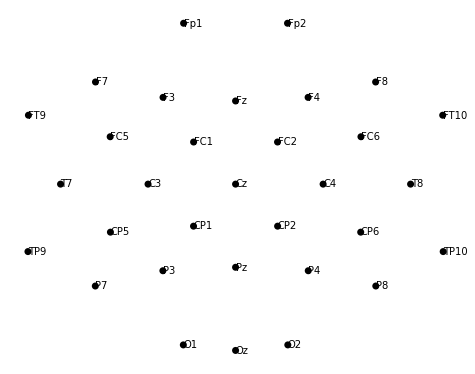

In [3]:
# Load data
data_path = os.path.join(data_dir, data_file)
raw_data = mne.io.read_raw_eeglab(data_path, preload=True, verbose=False)

# Show info (dict containing relevant metadata)
print(raw_data.info)

# Display the montage (sensors on the scalp)
plt.rcParams['figure.dpi'] = 150
raw_data.plot_sensors(ch_type='eeg',show_names=True)
plt.show()

## Now let us explore the EEG data.
As previously, the data array has a shape of (channels, time). We use the `get_data()` method to obtain the EEG array.

In [4]:
data_array = raw_data.get_data()

# Print the shape of the data
print(data_array.shape)

(32, 143722)


As previously stated, this data was acquired using a sampling frequency of 500Hz. We can recover this parameter from the `info` structure. This will be useful as we progress, but for now let's find out how long our data is in seconds.

In [5]:
sfreq = raw_data.info['sfreq']  # Sampling frequency
seconds = data_array.shape[-1] // sfreq
print(f'Data duration in seconds: {seconds} (around {seconds // 60} minutes)')

Data duration in seconds: 287.0 (around 4.0 minutes)


Data can be conveniently plotted from the raw object directly, allowing us some handy operations like filtering the data before displaying

In [6]:
plt.rcParams['figure.dpi'] = 150
scal = dict(eeg=1e-3)                      # EDIT ME!
raw_data.plot(n_channels=32, scalings=scal,
              start=15, duration=2,             # EDIT ME!
              lowpass=40, highpass=2,          # EDIT ME!
              show_scrollbars=False, show_scalebars=False)
plt.show()

Setting up band-pass filter from 2 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 2.00, 40.00 Hz: -6.02, -6.02 dB

Using qt as 2D backend.
Channels marked as bad:
none


### Let's explore some of the events
In this case, we find the events on an annotation file. Several ways of storing events exist, please refer to [the MNE documentation](https://mne.tools/dev/auto_tutorials/raw/20_event_arrays.html) to learn more about how to interact with different types of events. Here, we use the `events_from_annotations()` function to load them.

In [7]:
# Annotations are part of the raw object
print(raw_data.annotations)
print()

# We load the events and the event_id
events, event_id = mne.events_from_annotations(raw_data, verbose=False)

# event_id is a dictionary that related each label to their event name
print(event_id)
print()

# The events are a list where each element is a 3-element list. The first element is the onset of the event, and the last one is the label according to event_id
print(events[:10])

# Not it is also a good time to extract labels from the events
# With this our labels go from 0 to n_class - 1
labels = events[:, -1]
labels -= 1

<Annotations | 60 segments: 32.000000 (15), 34.000000 (15), 36.000000 ...>

{'32.000000': 1, '34.000000': 2, '36.000000': 3, '38.000000': 4}

[[ 6149     0     1]
 [ 7999     0     4]
 [ 9849     0     3]
 [11699     0     2]
 [14041     0     2]
 [15891     0     4]
 [17741     0     1]
 [19591     0     3]
 [22009     0     4]
 [23859     0     2]]


In [8]:
# Display EEG signal with some events
scal = dict(eeg=1e-3)     # EDIT ME!
plt.rcParams['figure.dpi'] = 150
raw_data.plot(events=events, event_color='red', event_id=event_id,
              scalings=scal, clipping=None, show_scrollbars=False, show_scalebars=False, 
              lowpass=40, highpass=2,          # EDIT ME!
              start=22, duration=40,  # EDIT ME!
              n_channels=32)
plt.show()

Setting up band-pass filter from 2 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 2.00, 40.00 Hz: -6.02, -6.02 dB

Channels marked as bad:
none


## Preprocessing Pipeline
We do not see a lot going on, for that we will have to move to the **frequency domain**, where we will be able to see and capture differences in frequency. Before that, we will have to pre-process the data. Different analysis require different pre-processing pipelines, and this time we will:

- Keep the relevant channels
- Band-pass filter the data
- Epoch the data

The only step that is new to this analysis is to keep a selection of channels. We will see an example first.

In [9]:
# To keep a selection of channels, first select the channels we want to keep
ch_to_keep = ["Fp1", "Fp2"]

# Make a list of the channels to drop
ch_to_drop = list(set(raw_data.ch_names) - set(ch_to_keep))
print(ch_to_drop)  # All the channels except ch_to_keep

# Drop the rest of the channels using the drop_channels() function
raw_data = raw_data.drop_channels(ch_to_drop)

['FT10', 'P3', 'O1', 'FC6', 'Oz', 'P4', 'TP9', 'P8', 'F4', 'T7', 'FC5', 'T8', 'O2', 'CP1', 'F3', 'F8', 'FC2', 'Pz', 'P7', 'CP2', 'Cz', 'FT9', 'Fz', 'F7', 'CP6', 'CP5', 'FC1', 'C4', 'TP10', 'C3']


**Question**: Load, pre-process, and epoch the data of a different subject using the functions presented until now. 

- Keep all the channels on the occipital (O) and parieto-occipital (PO) area
- Keep in mind the frequency of the stimuli for filtering (i.e., make sure to capture all the stimulation frequencies)
- Epoch between 0 and 2s, with a baseline of (0.2, 2)

In [11]:
# Load the data 
question_file = 'P2_low_100.set'

data_path = os.path.join(data_dir, question_file)
raw_data = mne.io.read_raw_eeglab(data_path, preload=True, verbose=False)  # HERE

# Get events and event_id
events, event_id = mne.events_from_annotations(raw_data, verbose=False)  # HERE

# Drop all channels except selection
ch_to_keep = ["P7", "P3", "Pz", "P4", "P8", "O1", "Oz", "O2"]  # HERE
ch_to_drop = list(set(raw_data.ch_names) - set(ch_to_keep))  # HERE

raw_data = raw_data.drop_channels(ch_to_drop)  # HERE

# Filter the data (notch and band-pass)
raw_data = raw_data.filter(l_freq=50.1, h_freq=49.9, method="iir", verbose=False)  # HERE
raw_data = raw_data.filter(l_freq=3, h_freq=120, method="iir", verbose=False)  # HERE

# Epoch the data
epochs = mne.Epochs(raw_data, events, event_id=event_id,  # HERE
                    tmin=0, tmax=2, baseline=(0.2, 2),
                    preload=True, verbose=False)

#### Hints: Functions to use. Open if you need a reminder of the functions necessary for the avobe exercise

- load data: `mne.io.read_raw_eeglab`
- find events: `mne.events_from_annotations`
- drop channels: `raw_data.drop_channels`
- filter: `raw_data.filter`
- epoch: `mne.Epochs`

#### Additional hints: Check if you feel lost

- You can check the signature of any function (how to call it, arguments, documentation, etc.) adding a '?' after its name in a jupyter notebook cell, for example, try running `mne.events_from_annotations?` on a new cell
- You can check the list of all EEG channels in `raw_data.info['ch_names']`
- You can check the stimulation frequencies with the `event_id` dictionary.

# II - Frequency analysis and signal-to-noise ratio
We will now explore our data in the frequency domain, and use this information to tell apart the different stimulation frequencies. The first step is to calculate the power spectral density (PSD) by calculating the Fourier Transform (FT).

The goal of this section is to separate the data into different frequencies and perform a statistical analysis to see if the difference in information is significative according to the spectral domain.

In [12]:
# Necessary parameters for the FT
tmin = 0.
tmax = 2.
fmin = 1.
fmax = 90.
sfreq = epochs.info['sfreq']

# In MNE, the FT is a special case of Welch's method
spectrum = epochs.compute_psd('welch',
                              n_fft=int(sfreq * (tmax - tmin)),
                              n_overlap=0, n_per_seg=None,
                              tmin=tmin, tmax=tmax,
                              fmin=fmin, fmax=fmax,
                              window='boxcar',
                              verbose=False)

psds, freqs = spectrum.get_data(return_freqs=True)

Now, we will proceed to calculate the signal-to-noise ratio (SNR). We define it here as a measure of relative power: it’s the ratio of power in a given frequency bin - the ‘signal’ - to a ‘noise’ baseline - the average power in the surrounding frequency bins.

Hence, we need to set some parameters for this baseline - how many neighboring bins should be taken for this computation, and do we want to skip the direct neighbors (this can make sense if the stimulation frequency is not super constant, or frequency bands are very narrow).

Here we provide a function that calculates the SNR: It depends on the PSD we just calculated and the noise of their neighbouring frequencies.

In [13]:
def snr_spectrum(psd, noise_n_neighbor_freqs=1, noise_skip_neighbor_freqs=1):
    """
    Compute SNR spectrum from PSD spectrum using convolution.

    Parameters
    ----------
    psd : ndarray, shape ([n_trials, n_channels,] n_frequency_bins)
        Data object containing PSD values. Works with arrays as produced by
        MNE's PSD functions or channel/trial subsets.
        
    noise_n_neighbor_freqs : int
        Number of neighboring frequencies used to compute noise level.
        increment by one to add one frequency bin ON BOTH SIDES
        
    noise_skip_neighbor_freqs : int
        set this >=1 if you want to exclude the immediately neighboring
        frequency bins in noise level calculation

    Returns
    -------
    snr : ndarray, shape ([n_trials, n_channels,] n_frequency_bins)
        Array containing SNR for all epochs, channels, frequency bins.
        NaN for frequencies on the edges, that do not have enough neighbors on
        one side to calculate SNR.
    """
    # Construct a kernel that calculates the mean of the neighboring frequencies
    averaging_kernel = np.concatenate((np.ones(noise_n_neighbor_freqs), 
                                       np.zeros(2 * noise_skip_neighbor_freqs + 1), 
                                       np.ones(noise_n_neighbor_freqs)))
    
    averaging_kernel /= averaging_kernel.sum()

    # Calculate the mean of the neighboring frequencies by convolving with the averaging kernel
    mean_noise = np.apply_along_axis(lambda psd_: np.convolve(psd_, averaging_kernel, mode='valid'), 
                                     axis=-1, arr=psd)

    # The mean is not defined on the edges so we will pad it with nas. The padding needs to be done 
    # for the last dimension only so we set it to (0, 0) for the other ones
    edge_width = noise_n_neighbor_freqs + noise_skip_neighbor_freqs
    pad_width = [(0, 0)] * (mean_noise.ndim - 1) + [(edge_width, edge_width)]
    mean_noise = np.pad(mean_noise, pad_width=pad_width, constant_values=np.nan)

    return psd / mean_noise

Now we call the function to compute our SNR spectrum.

As described above, we have to define two parameters.

- How many noise bins do we want?

- Do we want to skip the n bins directly next to the target bin?

Tweaking these parameters can drastically impact the resulting spectrum, but mainly if you choose extremes. E.g. if you’d skip very many neighboring bins, broad band power modulations (such as the alpha peak) should reappear in the SNR spectrum. On the other hand, if you skip none you might miss or smear peaks if the induced power is distributed over two or more frequency bins (e.g. if the stimulation frequency isn’t perfectly constant, or you have very narrow bins).

Here, we want to compare power at each bin with average power of the three neighboring bins (on each side) and **skip one bin** directly next to it.

In [14]:
snrs = snr_spectrum(psds, noise_n_neighbor_freqs=3,
                    noise_skip_neighbor_freqs=1)

Now, we can plot the psd and the SNR to have an overview of the frequency domain for our data

/tmp/ipykernel_168414/3303805546.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


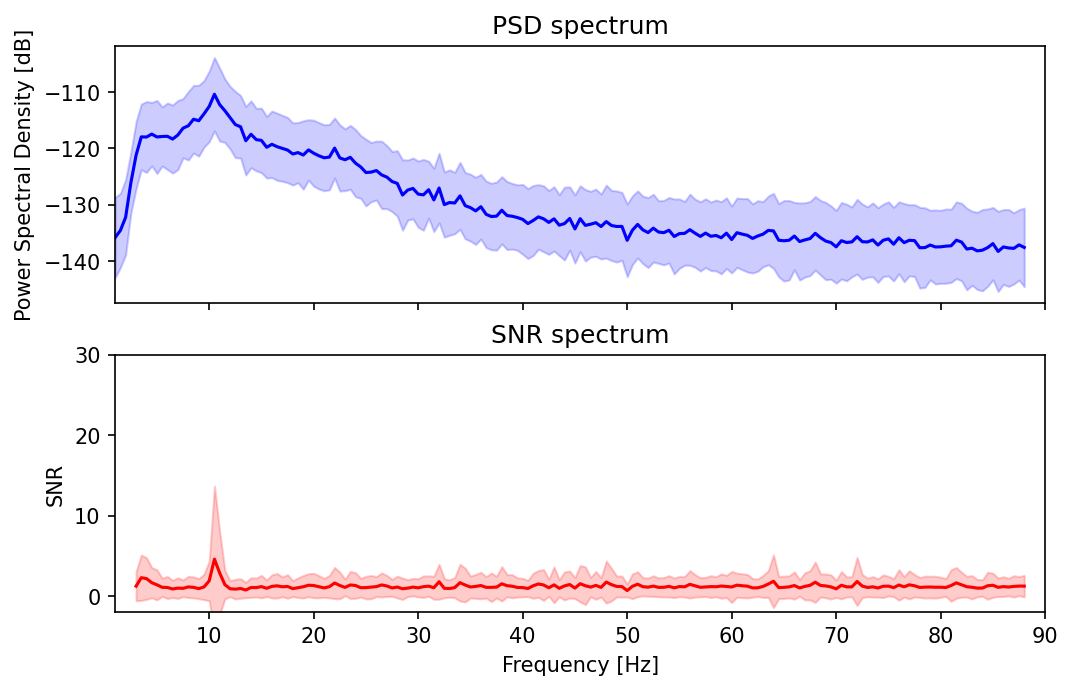

In [15]:
fig, axes = plt.subplots(2, 1, sharex='all', sharey='none', figsize=(8, 5))
freq_range = range(np.where(np.floor(freqs) == 1.)[0][0],
                   np.where(np.ceil(freqs) == fmax - 1)[0][0])

psds_plot = 10 * np.log10(psds)
psds_mean = psds_plot.mean(axis=(0, 1))[freq_range]
psds_std = psds_plot.std(axis=(0, 1))[freq_range]
axes[0].plot(freqs[freq_range], psds_mean, color='b')
axes[0].fill_between(
    freqs[freq_range], psds_mean - psds_std, psds_mean + psds_std,
    color='b', alpha=.2)
axes[0].set(title="PSD spectrum", ylabel='Power Spectral Density [dB]')

# SNR spectrum
snr_mean = snrs.mean(axis=(0, 1))[freq_range]
snr_std = snrs.std(axis=(0, 1))[freq_range]

axes[1].plot(freqs[freq_range], snr_mean, color='r')
axes[1].fill_between(
    freqs[freq_range], snr_mean - snr_std, snr_mean + snr_std,
    color='r', alpha=.2)
axes[1].set(
    title="SNR spectrum", xlabel='Frequency [Hz]',
    ylabel='SNR', ylim=[-2, 30], xlim=[fmin, fmax])
fig.show()

#### Extract SNR values at stim frequency
Our processing yielded a large array of many SNR values for each trial × channel × frequency-bin of the PSD array.

For statistical analysis we obviously need to define specific subsets of this array. First of all, we are only interested in SNR at the stimulation frequency, but we also want to restrict the analysis to a spatial ROI. Lastly, answering your interesting research questions will probably rely on comparing SNR in different trials.

Therefore we will have to find the indices of trials, channels, etc. Alternatively, one could subselect the trials already at the epoching step, using MNE’s event information, and process different epoch structures separately. Let's only have a look at the trials with 32Hz stimulation:

In [ ]:
# Define stimulation frequency 
stim_freq = 12

# Find index of frequency bin closest to stimulation frequency
i_bin_12hz = np.argmin(abs(freqs - stim_freq))

# Indices for different trial types
i_trial_12hz = np.where(epochs.events[:, 2] == event_id['12.000000'])[0]

# Check SNR of the target
snrs_target = snrs[i_trial_12hz, :, i_bin_12hz]
print("sub 2, 12 Hz trials, SNR at 12 Hz")
print(f'average SNR (occipital ROI): {snrs_target.mean()}')

In [17]:
data = epochs.get_data()

# Get labels from events
labels = epochs.events[:, -1]
labels -= 1
data12 = data[labels == 0]

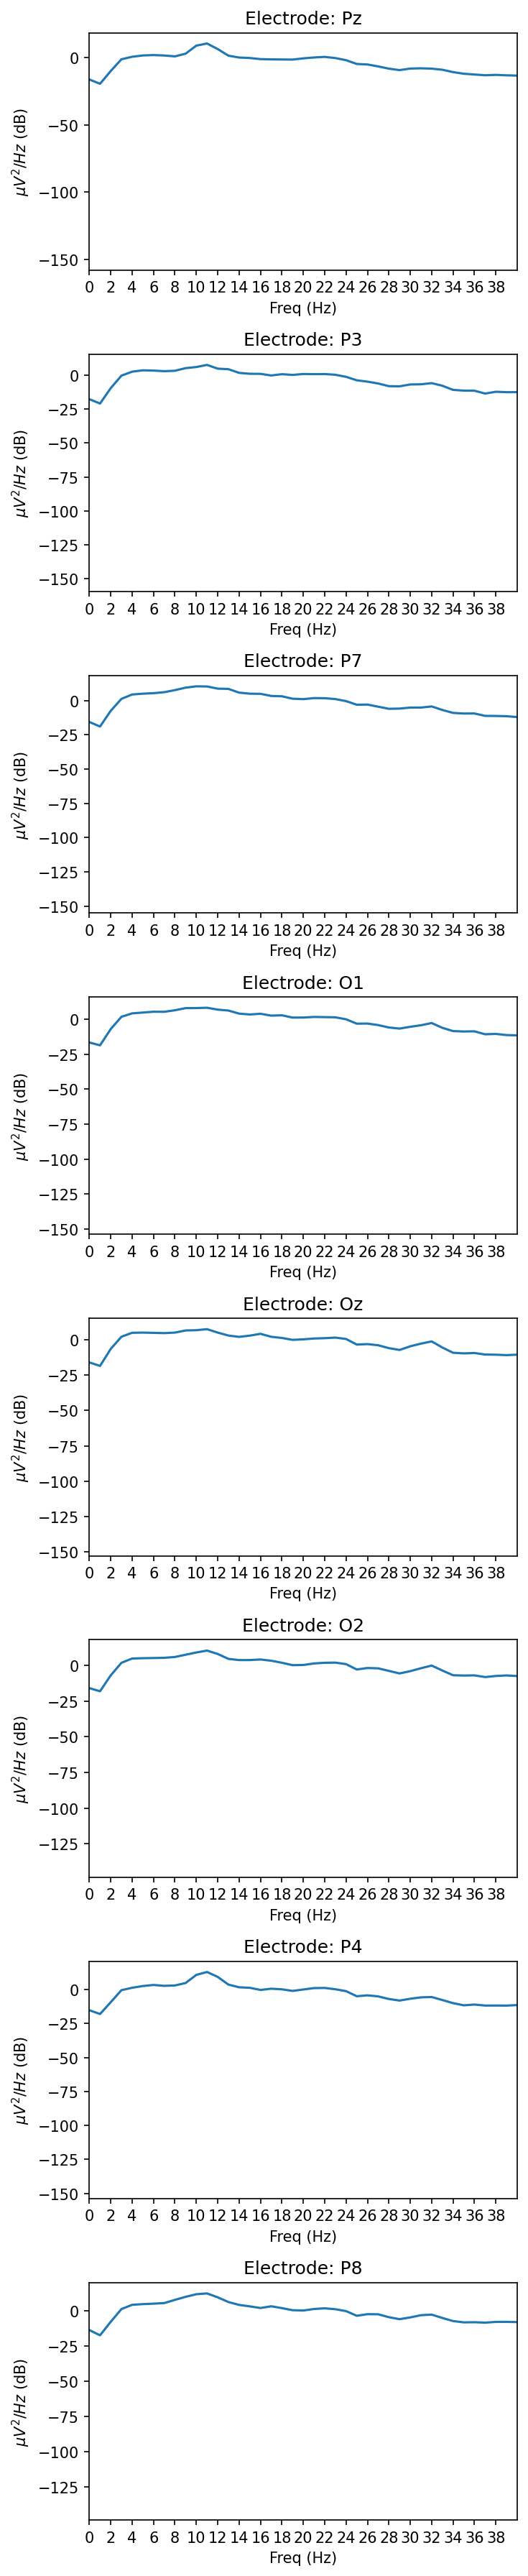

In [27]:
f, psd = welch(data12, sfreq, nperseg=sfreq)
psd = 10*np.log10(psd*1e6**2)
psd_trial = np.mean(psd, axis=0)
# psd_mean = np.mean(psd_trial, axis=0)
N = len(data12)
n = np.arange(N)
T = N/sfreq
freq = n/T 

ch_names = epochs.info['ch_names']
fig, axes = plt.subplots(len(ch_names), figsize=(5, 3 * len(ch_names)))

for i, ch_name in enumerate(ch_names):
    #axes[i].stem(f, np.sqrt(psd_trial[i]), linefmt='b', markerfmt=" ", basefmt="-b")
    axes[i].plot(f,psd_trial[i])#linefmt='b', markerfmt=" ", basefmt="-b")
    axes[i].set_xlabel('Freq (Hz)')
    axes[i].set_ylabel('$\mu V^2/Hz$ (dB)')
    axes[i].title.set_text(f'Electrode: {ch_names[i]}')
    
    axes[i].set_xticks(range(0, 40, 2))
    axes[i].set_xlim(0, 40)
    
fig.tight_layout()
plt.show()

# III - First classification using Canonical Correlation Analysis (CCA)
After having explored the frequency domain, we will now exploit this information to try to classify the different trials using various methods.

The first of them is Canonical Correlation Analysis (CCA). This method takes two random multivariate variables, $X$ and $Y$, and finds a transformation vector that makes the two of them be maximally correlated (this correlation is the so-called 'Canonical Correlation'). For more information, you can read the [CCA page on the Scikit-Learn documentation](https://scikit-learn.org/stable/modules/cross_decomposition.html#canonical-correlation-analysis).

The goal of this section is to lean how we can use CCA for our classification, and create a pipeline to classify the data from one of our participants. We will continue from the `epochs` object we created at the end of section I.

## What are we comparing our signal to?
As previously discussed, the stimulation were presented at certain frequencies. We also know that the brain activity in occipital areas shows a peak of activity at the frequency of stimulation. Knowing that, we can create 'artificial' signals that are perfect sinusoids at our target frequencies, for example:

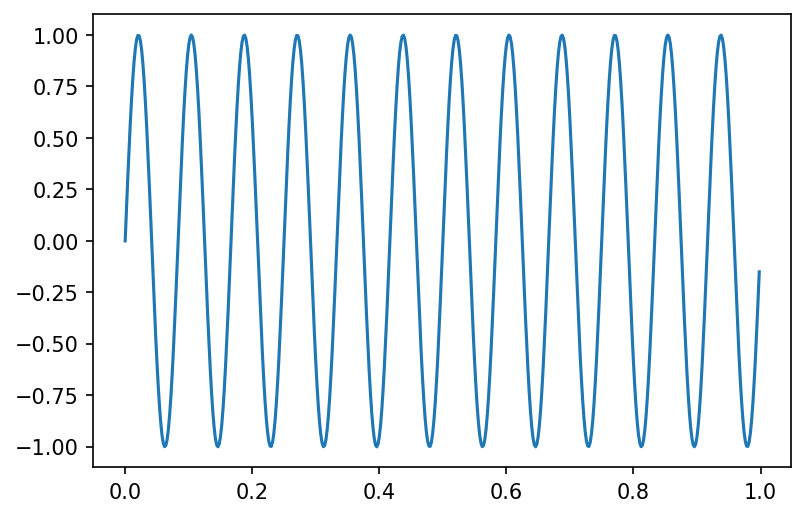

In [13]:
peak = 12  # Target frequency
trial_len = 1  # Length of the wave in seconds

# Time points for our wave 
t = np.arange(0, trial_len, 1 / sfreq)
sin = np.sin(2 * np.pi * peak * t)

plt.plot(t, sin)
plt.show()

And just like that, we created a perfect sinusoid at one of the stimulation frequencies! To make things better for CCA, each frequency will be compared with a pair of sine and cosine waves at their frequency, as well as pairs of waves corresponding to their harmonics (i.e. freq * N), like so:

In [14]:
n_harmonics = 2

pairs = 1 + n_harmonics  # Include the frequency itself
harmonics = [i + 1 for i in range(pairs)]  # This gives us the list of numbers we need to multiply our taget freq by (including 1)
n_waves = pairs * 2  

all_waves = []
for i in harmonics:
    target_freq = i * peak

    sin = np.sin(2 * np.pi * (target_freq) * t)
    cos = np.cos(2 * np.pi * (target_freq) * t)

    all_waves.append(sin)
    all_waves.append(cos)

template = np.vstack(all_waves)  # (waves, samples)

We will call this the 'template' for that particular stimulation frequency. We need to create one for each frequency and then, we will compare each trial of real data to all the templates, and we will consider the one that shows the highest correlation the predicted class of the data. 

**Question**: Make the templates for all classes in a single array

- Define the list of target frequencies
- Define the number of harmonics and total number of waves for each template
- Define the length of the waves, that needs to be equal to the length of the data epochs (in samples)
- Make an empty 3D array of shape (n_class, n_waves, trial_len)
- Iterate over peak frequencies and then over the harmonics to make the pairs of waves, stack all waves in one array and put them on the empty 3D array

In [15]:
# Get target frequency list
event_id = epochs.event_id
peaks = [float(peak) for peak in event_id.keys()]  # HERE

# Get number of harmonics and total waves
n_harmonics = 2
pairs = 1 + n_harmonics  # Including the frequency itself

harmonics = [i + 1 for i in range(pairs)]  # HERE
n_waves = pairs * 2  # HERE

# Get lenght of the wave (length of trials)
data = epochs.get_data()
trial_len = data.shape[-1]  # HERE

# Make time points 't'
t = np.arange(0, trial_len / sfreq, 1 / sfreq)  # HERE

# Create empty array
n_class = len(peaks)  # HERE
ref_signals = np.zeros((n_class, n_waves, trial_len))  # HERE

# Iterate over peaks (the index will be needed to add waves to ref_signals at the end
for class_idx, peak in enumerate(peaks):
    all_waves = []  # HERE
    
    # Iterate over harmonics
    for i in harmonics:
        target_freq = i * peak  # HERE 

        sin = np.sin(2 * np.pi * target_freq * t)  # HERE
        cos = np.cos(2 * np.pi * target_freq * t)  # HERE

        # Append the waves you just created 
        all_waves.append(sin)
        all_waves.append(cos)
        
    # Stack to get an array of shape (waves, samples)
    y = np.vstack(all_waves)  # HERE
    
    # Add to the empty array
    ref_signals[class_idx, :, :] = y  # HERE

#### Hints: Check here if you feel lost with the exercise

- In order to get the length of the trials, you can retrieve the data array with `epochs.get_data()`. The shape of this array is (n_trials, n_channels, n_samples)
- You can create a 3D array using the function `np.zeros()`. If you want an array of shape (3, 2, 4), you can make it with `np.zeros((3, 2, 4))`
- To assign a 2D array to the first dimension of a 3D array (i.e., set a (2, 4) `template` array) as the first element of your (3, 2, 4) `all_templates` array, you can do it with `all_templates[0, :, :] = template`
- As a reminder, the stimulation frequencies are stores in the `event_id` dict, that can be retrieved from your `epochs` with `epochs.event_id`

## CCA classification
Now we have our `ref_signals` dict. Inside of it are the perfect signals that we will use for all our frequency stimulations. Now the next question is: How do we exactly use these to classify our data? The process is as follows:

- We extract one epoch of data and find its true label from the `labels` array
- We iterate over our target frequencies and select the corresponding template
  - For each template, we fit a CCA model using our epoch and the template as $X$ and $Y$ variables
  - We transform them using the CCA model
  - We calculate the correlation between the transformed arrays and store it as the correlation for the corresponding class
- Finally, we take the argmax of the list with all the correlations as the predicted label for that trial

We will now see an example with one trial of data before proceeding to the final exercise of this section when you will implement the classification for all trials

In [16]:
# First trial
ex_trial = data[0, ...]
ex_label = labels[0]

# Create the CCA model
cca = CCA(n_components=1, max_iter=1000)

# Empty list to store the correlations
corrs = []

# Iterate over classes
for class_idx in range(len(peaks)):
    # Get the corresponding template
    template = ref_signals[class_idx, :, :]
    
    # Fit CCA and transform
    cca.fit(ex_trial.T, template.T)
    x_scores, y_scores = cca.transform(ex_trial.T, template.T)
    
    # Get correlation
    corr_score = np.corrcoef(x_scores, y_scores, rowvar=False)[0, 1]
    corrs.append(corr_score)
    
pred = np.argmax(corrs)
print(f'True label: {ex_label}')
print(f'Predicted label: {pred}')

True label: 0
Predicted label: 0


Now that we know how the process works for a single trial, it is time to do the same with all of them and put our newly acquired classifier to the test!

**Question**: Build a CCA classifier and report the classification accuracy on one of our participants. You can use the same `epochs` and `ref_signals` from the previous exercises, we will focus only in building a loop for the classification.

- Create an empty list `pred` for the prediced classes for all the trials
- Create the CCA model at the beginning (no need to create a new one for each trial)
- Loop over the data trials. For each trial:
  - Repeat the single trial classification as before
  - Append the predicted label to your `pred` list
- Calculate and print the final accuracy

No hints for this one, I believe in you :D

In [17]:
# Empty list for predictions
y_pred = []

# CCA model
cca = CCA(n_components=1, max_iter=1000)

# Loop over trials
n_trials, _, _ = data.shape

for trial_n in range(n_trials):
    # Empty list to store the correlations
    corrs = []
    next_trial = data[trial_n, ...]

    # Iterate over classes
    for class_idx in range(len(peaks)):
        # Get the corresponding template
        template = ref_signals[class_idx, :, :]

        # Fit CCA and transform
        cca.fit(next_trial.T, template.T)
        x_scores, y_scores = cca.transform(next_trial.T, template.T)

        # Get correlation
        corr_score = np.corrcoef(x_scores, y_scores, rowvar=False)[0, 1]
        corrs.append(corr_score)
    
    # Append the label of the max correlation to the pred list
    trial_pred = np.argmax(corrs)
    y_pred.append(trial_pred)

# Get accuracy
acc_score = accuracy_score(labels, y_pred)
print(f'Total accuracy score: {acc_score}')

Total accuracy score: 0.7333333333333333


Well done! We have a good performance, accounting for the fact that we are using artificial data as templates. Research has proposed using CCA but creating templates from the data itself, more similar to a traditional machine learning approach (train -> create templates, test -> classification). Since demonstrating it would be too similar to what we just did, we are now moving to a classification approach specific to SSVEP data.

# IV - SSVEP classification using TRCA
Task-Related Component Analysis (TRCA) is an approach that share many similarities (conceptually, at least) with CCA. On this section, we will cover the process of TRCA and implement a classification pipeline that leverages it for our SSVEP data. We will not dive into the specifics of the approach, nor we will implement every step from scratch, so for those interested in the 'guts' of the model, refer to [the original TRCA paper](https://ieeexplore.ieee.org/abstract/document/7904641)

## How does TRCA work?
Simply put, TRCA creates a "class template" for each frequency by averaging data trials of the same class. Then, using the templates for all classes, TRCA computes linear filters that maximize the similarity between examples of the same class, while maximizing the differences between examples of different classes. This is similar to how CCA allowed us to transform our data and template so they had maximum correlation. From here, the classification process is similar to what we did with CCA:

- A data trial is extracted
- The process iterates over all classes
  - For each class, the data and the corresponding template are multiplied by the TRCA-filters
  - Then, the correlation between the two is calculated
- Finally, the class that holds the maximum correlation is considered the predicted class

Additionally, TRCA leverages a filtering approach called 'filterbank'. Templates, filters and data are divided into 'bands' at different frequencies. All the process described above is performed for all the specified frequency bands and the results are combined before the classification decision is taken.

## Classification
We provide you with a sklearn-compatible TRCA. Similarly to other classification algorithms that you have used, it uses a `fit()` method to calculate the templates and spatial filter and a `predict()` method that will give you the predicted labels for your test data.

## TRCA specifics
Before moving on to classification, we have to note some particularities for TRCA. First, the authors describe the need to omit the first 0.14 seconds (approximately) of data after each stimulus presentation. The reason is that this is the time that the information takes to reach the visual cortex. Also, we will perform the classification on the first second of data. With all this, we will take our data epochs and select a slice from 0.14 to 1.14 seconds. Finally, we will take this chance to specify the number of bands for filterbank, as well as the downsample parameter for TRCA

In [16]:
init_delay = 0.14
epoch_len = 1.
n_fbands = 4
downsample = 2  # The original study downsampled to 250Hz, so we will do the same

# Get t_min and t_max in samples to slice the data
t_min = int(init_delay * sfreq) + 1
t_max = int(t_min + epoch_len * sfreq)

# Slice the data
data_slice = data[..., t_min:t_max]

**Question**: Classify the data using TRCA.

Now that we have an intuition about how TRCA works, the only thing left for us to do is to build a classification pipeline. For that, you will have to:

- Start from the same `epochs` object we have been using so far
- Split the data into train and test using an aprox of 33% testing data
- Fit the train data and test on the testing data
- Compute and print the accuracy of your classification

When creating the TRCA model, you will have to provide the following arguments: `sfreq`, `n_fbands`, `peaks` and `downsample`

In [31]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(data_slice, labels, test_size=0.33)  # HERE

# Classifier
clf = TRCA(sfreq=sfreq, n_fbands=n_fbands, peaks=peaks, downsample=downsample)  # HERE

# Fit and predict
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f'TRCA accuracy: {acc}')

TRCA accuracy: 0.75
